# Basics CML processing workflow

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%matplotlib inline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import xarray as xr
import pandas as pd

import pycomlink as pycml

# Load example data and do preprocessing

We load the example data from one NetCDF file which contains the time series of 500 CMLs over 10 days. If you want to use your own data, e.g. from a CSV file, look at the respective example notebook for how to get started.

In [2]:
data_path = pycml.io.examples.get_example_data_path()

cmls = xr.open_dataset(data_path + '/example_cml_data.nc')
cmls

<xarray.Dataset>
Dimensions:           (time: 15840, cml_id: 500, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id            (cml_id) object '0' '1' '2' '3' ... '497' '498' '499'
    length            (cml_id) float64 ...
    site_a_latitude   (cml_id) float64 ...
    site_a_longitude  (cml_id) float64 ...
    site_b_latitude   (cml_id) float64 ...
    site_b_longitude  (cml_id) float64 ...
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 ...
    polarization      (cml_id, channel_id) object ...
Data variables:
    rsl               (channel_id, cml_id, time) float32 ...
    tsl               (channel_id, cml_id, time) float32 ...

# Have a quick look at the data of one CML

We store each CML as item of a list because we want to do the processing per CML.

In the plot, note that there are some outliers. These correspond to fill values, which we get rid of in the next step.

In [3]:
cml_list = [cmls.isel(cml_id=i) for i in range(len(cmls.cml_id))]

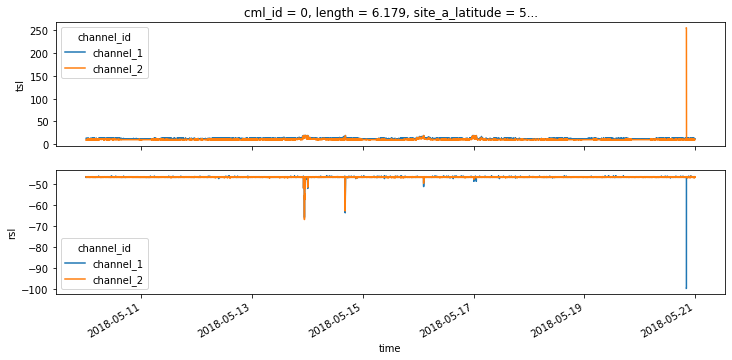

In [4]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,5))
cml_list[0].tsl.plot.line(x='time', ax=axs[0])
cml_list[0].rsl.plot.line(x='time', ax=axs[1])
axs[0].set_xlabel('')
axs[1].set_title('');

# Set default and fill values to NaN and calculate TRSL
TRSL is the transmitted signal level minus the received signal level and represents the total path loss along the CML.

In [5]:
for cml in cml_list:
    cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
    cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
    cml['trsl'] = cml.tsl - cml.rsl

We can now also see TSL and RSL withouth the fill values that we removed.

Also note that TRSL changes during weak attenuation events stem mostly from TSL changes because this CML has automatic transmission power control (ATPC) which tries to keep RSL constant as long as possible by increasing TSL when path-attenuation occurs.

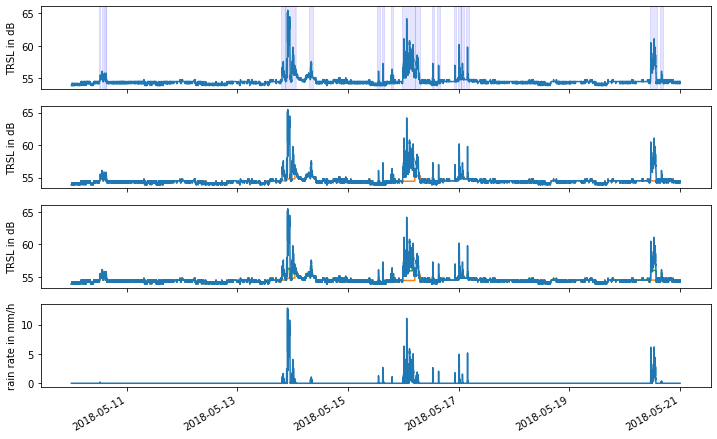

In [85]:
cml = cml_list[10].isel(channel_id=0)

cml['trsl'] = cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')

threshold = 0.4

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12,7))



cml.trsl.plot.line(x='time', ax=axs[0]);

## WET-DRY

roll_std_dev = cml.trsl.rolling(time=60, center=True).std()
cml['wet'] = cml.trsl.rolling(time=60, center=True).std() > threshold

# Get start and end of dry event
wet_start = np.roll(cml.wet, -1) & ~cml.wet
wet_end = np.roll(cml.wet, 1) & ~cml.wet

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[0].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)

axs[0].set_ylabel('TRSL in dB');

## BASELINE

cml['baseline'] = pycml.processing.baseline.baseline_constant(trsl=cml.trsl, wet=cml.wet, n_average_last_dry=5)

cml.trsl.plot.line(x='time', alpha=1, ax=axs[1])
cml.baseline.plot.line(x='time', ax=axs[1], zorder=-3);
axs[1].set_ylabel('TRSL in dB');

# WAA

cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl, 
    baseline=cml.baseline, 
    wet=cml.wet, 
    waa_max=1.5, 
    delta_t=1, 
    tau=20,
)

#(cml.trsl - cml.baseline).plot.line(x='time', alpha=1, ax=axs[2])
cml.trsl.plot.line(x='time', alpha=1, ax=axs[2])
cml.baseline.plot.line(x='time', ax=axs[2], zorder=-3);
(cml.waa + cml.baseline).plot.line(x='time', ax=axs[2], zorder=0)

axs[2].set_ylabel('TRSL in dB');

## Rain rate

cml['A'] = cml.trsl - cml.baseline - cml.waa
cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(A=cml.A, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization)

cml.R.plot.line(x='time', ax=axs[3])
axs[3].set_ylabel('rain rate in mm/h');


[ax.set_title('') for ax in axs];
[ax.set_xlabel('') for ax in axs];
#[ax.set_xticks([]) for ax in axs];

#axs[1].set_xlim(pd.to_datetime('2018-05-13 12:00:00'), pd.to_datetime('2018-05-14 12:00:00'));

#axs[3].set_xticklabels('');

#fig.savefig('no_wetdry.png', dpi=300)
#fig.savefig('with_wetdry.png', dpi=300)
#fig.savefig('all_zoommed.png', dpi=300)

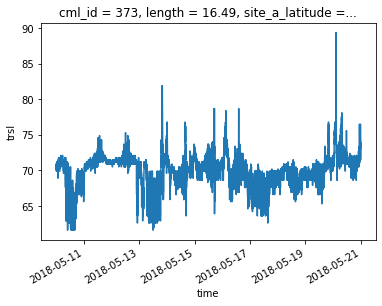

In [113]:
import pandas as pd

cml = cml_list[373].isel(channel_id=0)
cml.trsl.plot()

In [202]:
df = cml.trsl.to_dataframe()
df['roll_autocorr'] =  df.trsl.rolling(60, center=True).apply(lambda x: x.autocorr(lag=1), raw=False)

In [199]:
path_ref = xr.open_dataset(data_path + '/example_path_averaged_reference_data.nc')
radar_along_cml = path_ref.sel(cml_id=cml.cml_id)

cml['wet_radar'] = radar_along_cml.rainfall_amount.rolling(time=5).max() >= 0.1
#cml['wet_radar'] = cml.wet_radar.astype('float').rolling(time=15).max()
cml['wet_radar'] = cml.wet_radar.fillna(False).astype('bool')

# Get start and end of dry event
wet_start = np.roll(cml.wet_radar, -1) & ~cml.wet_radar
wet_end = np.roll(cml.wet_radar, 1) & ~cml.wet_radar

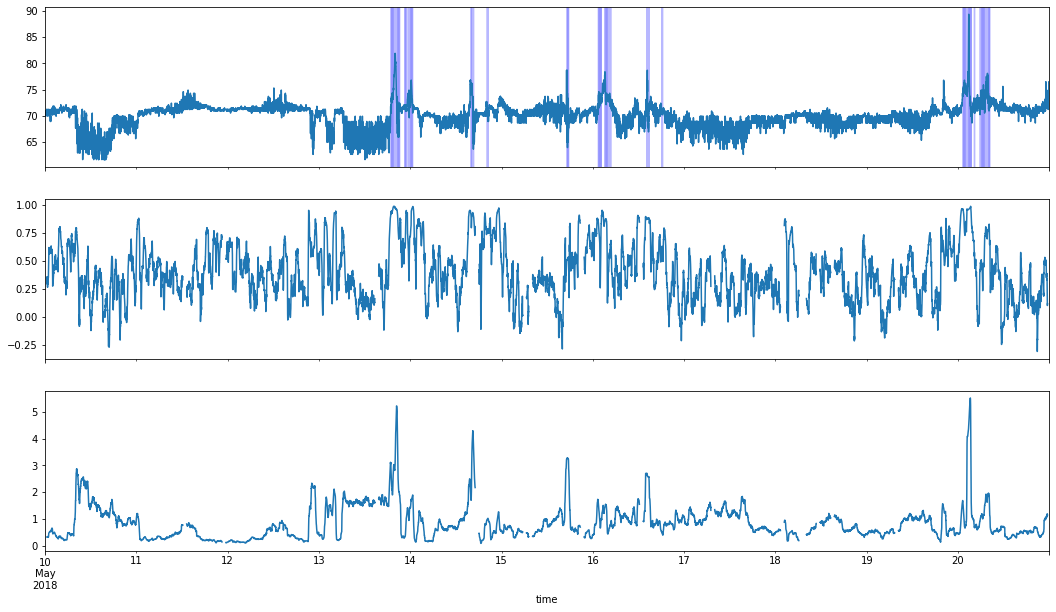

In [203]:
fig, axs = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
df.trsl.plot(ax=axs[0])
df.trsl.rolling(60, center=True).std().plot(ax=axs[2])
df.roll_autocorr.plot(ax=axs[1])

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[0].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)


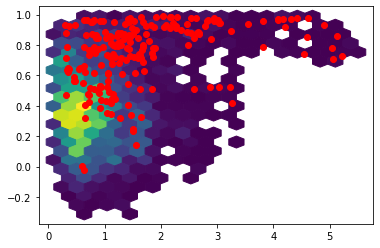

In [206]:
plt.hexbin(
    df.trsl.rolling(60).std(),
    df.roll_autocorr,
    mincnt=1,
    gridsize=20,
)

plt.scatter(
    df.trsl.rolling(60).std().values[cml.wet_radar],
    df.roll_autocorr.values[cml.wet_radar],
    c='r',
)

In [267]:
from shapely.geometry import LineString, Point, Polygon, MultiLineString

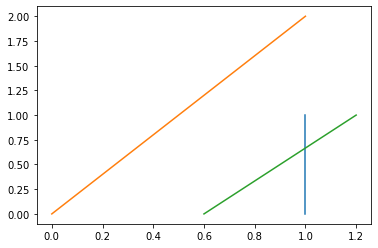

In [261]:
line1 = LineString([[1, 0], [1, 1]])
line2 = LineString([[0, 0], [1, 2]])
line3 = LineString([[0.6, 0], [1.2, 1]])

plt.plot(*line1.xy)
plt.plot(*line2.xy)
plt.plot(*line3.xy)

In [266]:
line1.distance(line2)

0.447213595499958

In [250]:
import shapely.geos

In [ ]:
shapely.geos.d

In [268]:
multi_line = MultiLineString([line1, line2, line3])

In [274]:
multi_line.distance(line2)

0.0

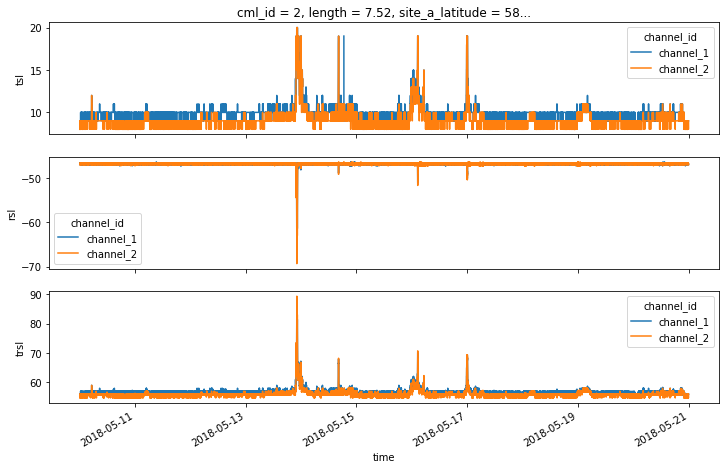

In [8]:
i = 2

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,7))
cml_list[i].tsl.plot.line(x='time', ax=axs[0])
cml_list[i].rsl.plot.line(x='time', ax=axs[1])
cml_list[i].trsl.plot.line(x='time', ax=axs[2])
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[1].set_title('')
axs[2].set_title('');

# Interpolate short gaps in TRSL 

Our CML data might have data gaps. These gaps can stem from outages of the data acuqisition or from blackout gaps. If they stem from a blackout gap, there are better methods than linear interpolation. See the notebook `Blackout gap detection example` for more details.

Here we stick to a simple linear interpolatoin of a maximum gap width of 5 minutes.

In [9]:
for cml in cml_list:
    cml['trsl'] = cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')

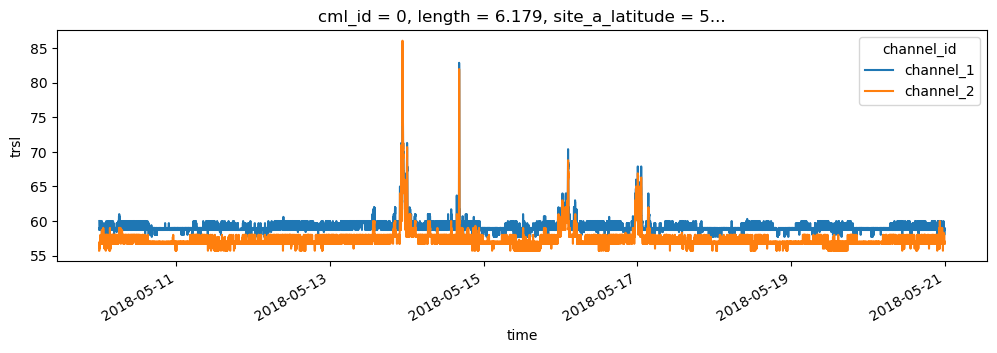

In [10]:
cml = cml_list[0].copy() # make a copy here to not change the CML dataset in the list over which we want to iterate later
cml.trsl.plot.line(x='time', figsize=(12,3));

# Do simple wet-dry classification using a rolling standard deviation 

This is the most basic way of doing a wet-dry classification. The crucial part here is to find the optimal threshold. To keep this example short, we use a standard value of 0.8 which is more or less suitable for most CML time series. But please note, that this threshold should be adapted to the noisiness of the individual CML time series, e.g. as in [Graf et al. 2020](https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020.html) to get the good performance for CML rainfall estimation.

In [11]:
threshold = 0.8

roll_std_dev = cml.trsl.rolling(time=60, center=True).std()
cml['wet'] = cml.trsl.rolling(time=60, center=True).std() > threshold

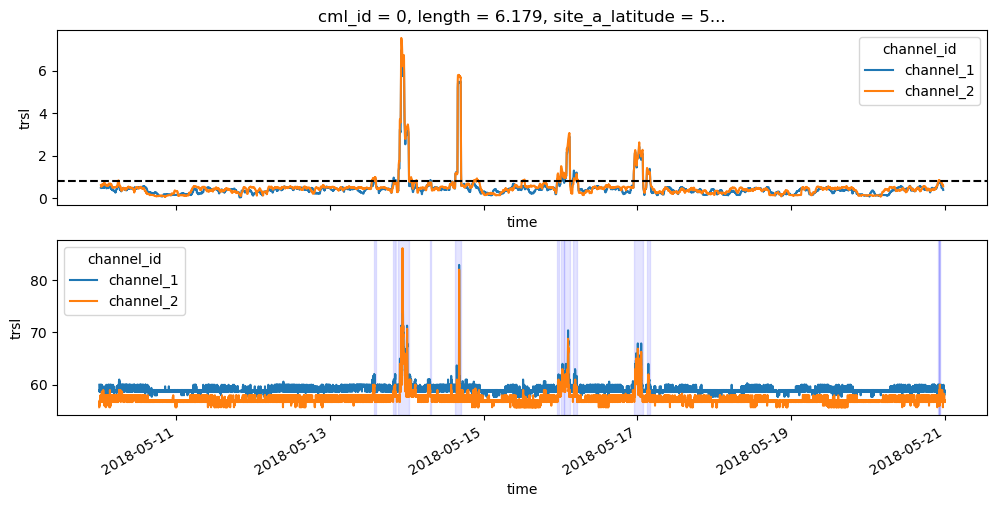

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

roll_std_dev.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--')

cml.trsl.plot.line(x='time', ax=axs[1]);

# Get start and end of dry event
wet_start = np.roll(cml.wet, -1) & ~cml.wet
wet_end = np.roll(cml.wet, 1) & ~cml.wet

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.isel(channel_id=0).values.nonzero()[0],
    wet_end.isel(channel_id=0).values.nonzero()[0],
):
    axs[1].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)

axs[1].set_title('');

# Determine baseline

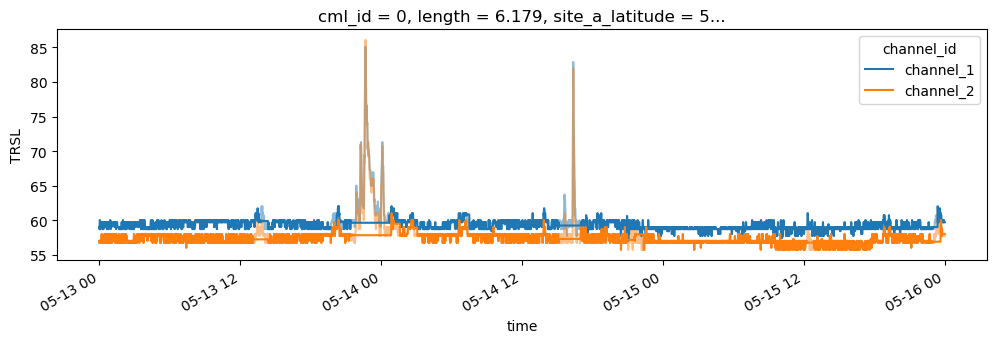

In [13]:
cml['baseline'] = pycml.processing.baseline.baseline_constant(trsl=cml.trsl, wet=cml.wet, n_average_last_dry=5)

fig, ax = plt.subplots(figsize=(12,3))

cml.trsl.sel(time=slice('2018-05-13', '2018-05-15')).plot.line(x='time', alpha=0.5)
plt.gca().set_prop_cycle(None)
cml.baseline.sel(time=slice('2018-05-13', '2018-05-15')).plot.line(x='time');
plt.gca().set_prop_cycle(None)
plt.ylabel('TRSL');

# Perform wet antenna estimation and compare to uncorrected baseline 

In [14]:
cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl, 
    baseline=cml.baseline, 
    wet=cml.wet, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

In [15]:
%matplotlib inline

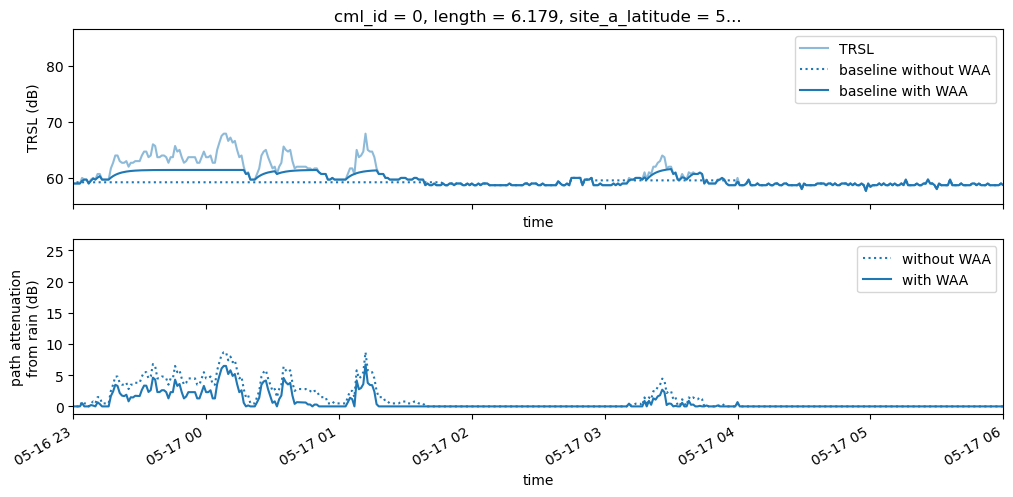

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

plt.sca(axs[0])
cml.isel(channel_id=0).trsl.plot.line(x='time', alpha=0.5, label='TRSL')
plt.gca().set_prop_cycle(None)
cml.isel(channel_id=0).baseline.plot.line(x='time', linestyle=':', label='baseline without WAA');
plt.gca().set_prop_cycle(None)
(cml.baseline + cml.waa).isel(channel_id=0).plot.line(x='time', label='baseline with WAA');
plt.ylabel('TRSL (dB)')
axs[0].legend()

# estimate WAA and correct baseline
cml['A'] = cml.trsl - cml.baseline - cml.waa
cml['A'].values[cml.A < 0] = 0
cml['A_no_waa_correct'] = cml.trsl - cml.baseline
cml['A_no_waa_correct'].values[cml.A_no_waa_correct < 0] = 0 

plt.sca(axs[1])
cml.A_no_waa_correct.isel(channel_id=0).plot.line(x='time', linestyle=':', label='without WAA');
plt.gca().set_prop_cycle(None)
cml.A.isel(channel_id=0).plot.line(x='time', label='with WAA');
plt.ylabel('path attenuation\nfrom rain (dB)');
axs[1].set_title('');
axs[1].legend()

axs[1].set_xlim(pd.to_datetime('2018-05-16 23:00:00'), pd.to_datetime('2018-05-17 06:00:00'));

# Calculate rain rate

In [17]:
cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(A=cml.A, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization)

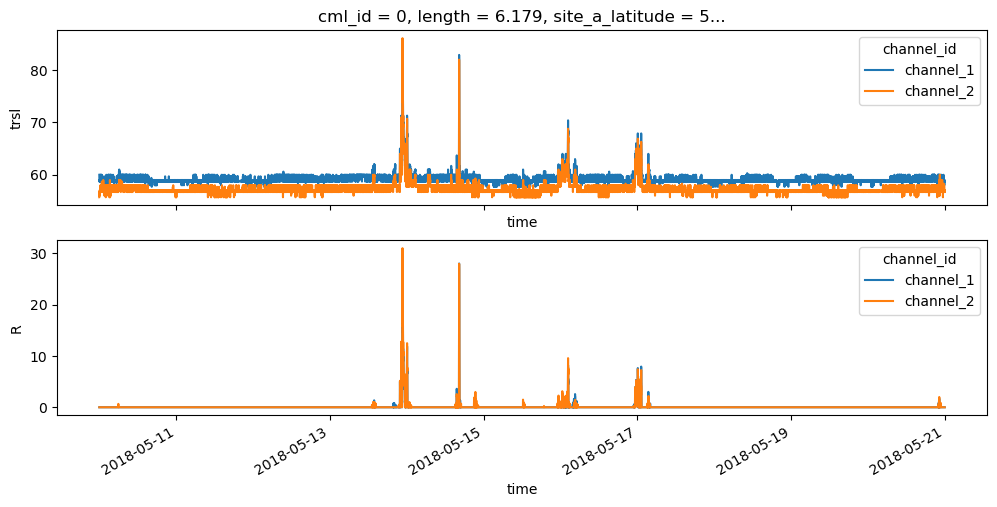

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)
cml.trsl.plot.line(x='time', ax=axs[0])
cml.R.plot.line(x='time', ax=axs[1])
axs[1].set_title('');

# Now do the whole processing for all CMLs 

In [19]:
for cml in tqdm.tqdm(cml_list):
    cml['wet'] = cml.trsl.rolling(time=60, center=True).std(skipna=False) > 0.8
    
    cml['wet_fraction'] = (cml.wet==1).sum() / len(cml.time)
    
    cml['baseline'] = pycml.processing.baseline.baseline_constant(
        trsl=cml.trsl, 
        wet=cml.wet, 
        n_average_last_dry=5,
    )
    cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
        rsl=cml.trsl, 
        baseline=cml.baseline, 
        wet=cml.wet, 
        waa_max=2.2, 
        delta_t=1, 
        tau=15,
    )
    cml['A'] = cml.trsl - cml.baseline - cml.waa
    
    # Note that we set A < 0 to 0 here, but it is not strictly required for 
    # the next step, because calc_R_from_A sets all rainfall rates below 
    # a certain threshold (default is 0.1) to 0. Some people might want to
    # keep A as it is to check later if there were negative numbers.
    cml['A'].values[cml.A < 0] = 0
    
    cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
        A=cml.A, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization
   )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 72.09it/s]


# Find CMLs that show erratic behavior 

Find the CMLs that have a very high ratio of wet/dry data. For the 10-day dataset that is used here and for central-European climate, a ratio higher than 0.3 can be considered very unlikely, i.e. it is unlikely that it was rainy for 30% of the one-minute data points within the 10-day period.

For the plots below, we use a higher threshold 0.8 to only plot a small number of CMLs, but find those that show very strong erratic behavior during dry periods.

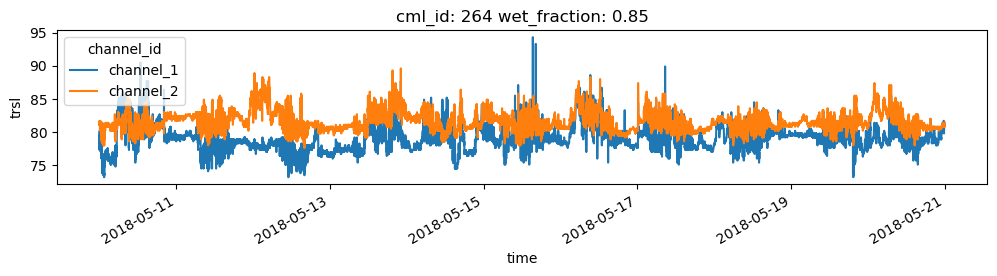

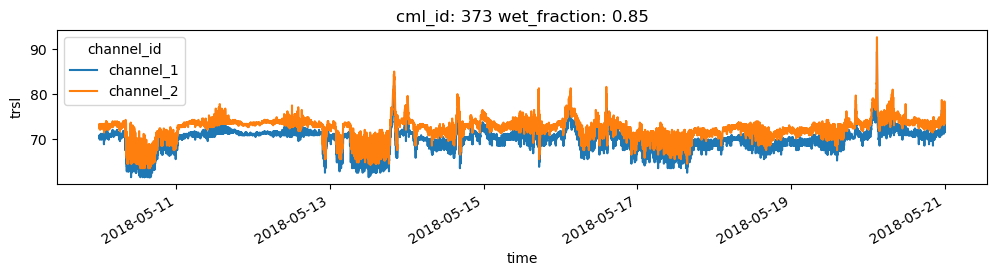

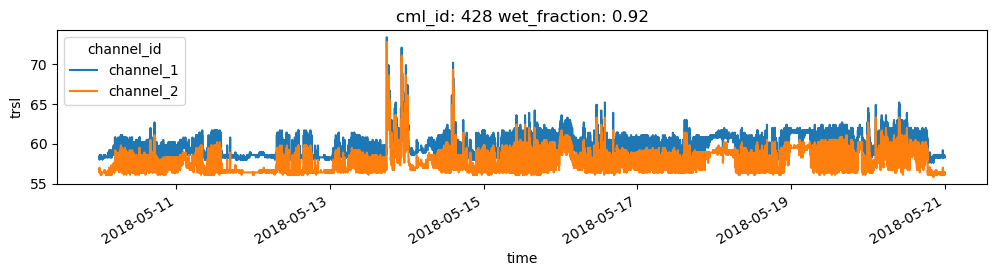

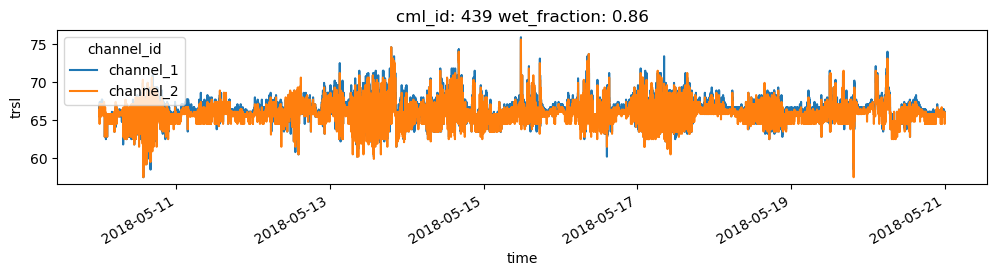

In [20]:
for cml in cml_list:
    if cml.wet_fraction > 0.8:
        cml.trsl.plot.line(x='time', figsize=(12,2))
        plt.title(f'cml_id: {cml.cml_id.values} wet_fraction: {cml.wet_fraction.values:0.2f}')
        plt.show()

# Compare derived rain rates with reference data

As reference, path-averaged rain rates along the CMLs paths from RADKLIM-YW are provided. This data has a temporal resolution of 5 minutes. First, we compare one CML timeseries aggregated to five minutes individually against its reference timeseries. Then we resample all cml data und prepare a scatterplot between CML and reference data. Finally some metrics are claculated. (for simplicity only `channel 1` is evaluated here)

In [21]:
path_ref = xr.open_dataset(data_path + '/example_path_averaged_reference_data.nc')

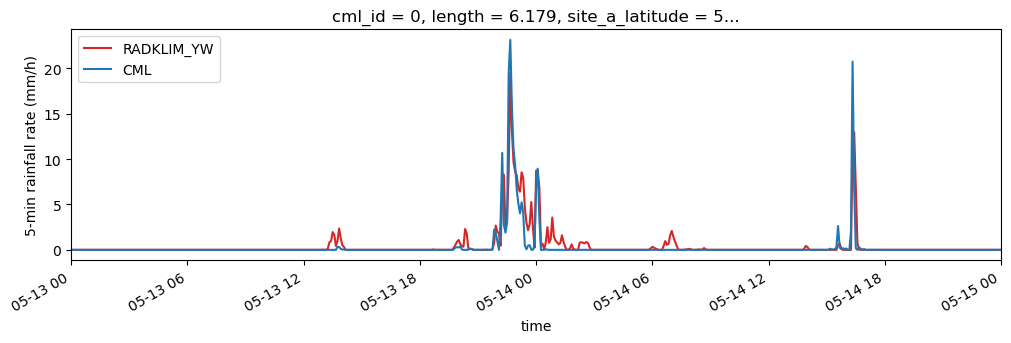

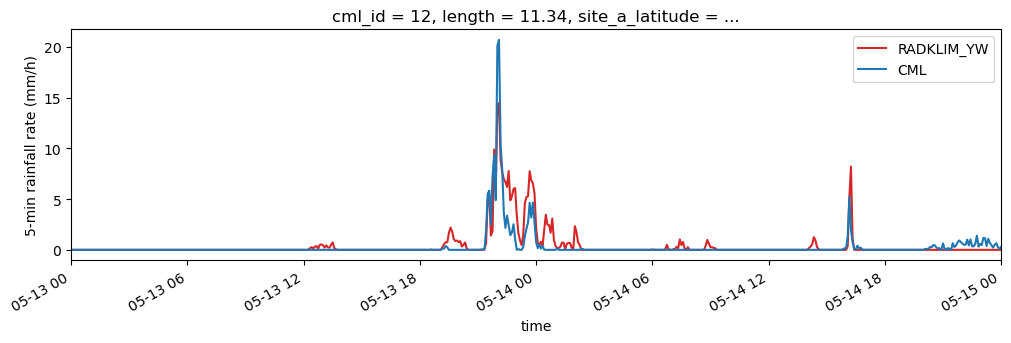

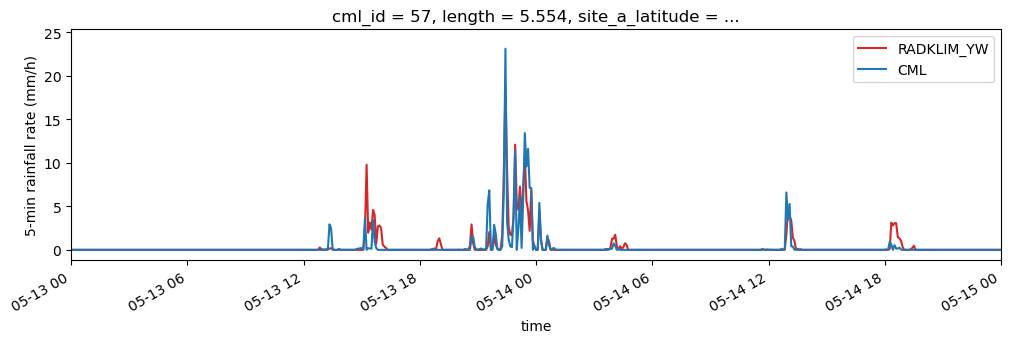

In [22]:
for i in [0, 12, 57]:
    # Plot reference rainfall amount (converted to 5-minute rainfall rate)
    (path_ref.sel(cml_id=cml_list[i].cml_id).rainfall_amount * 12).plot(
        label="RADKLIM_YW", color='C3', figsize=(12,3)
    )
    # Plot 5-minute mean rainfall rates from CMLs
    (cml_list[i].sel(channel_id="channel_1").R.resample(time="5min").mean()).plot(
        x="time", label="CML", color='C0'
    )
    
    plt.xlim(pd.to_datetime('2018-05-13'), pd.to_datetime('2018-05-15'))
    plt.ylabel('5-min rainfall rate (mm/h)')
    plt.legend();

Aggregate the CML data to 5 minute rainfall sums and concat the indiviudal CML `xarray.Dataset`s to one joint `xarray.Dataset` for the comparison with the reference.

In [23]:
ds_cmls = xr.concat(cml_list, dim='cml_id')

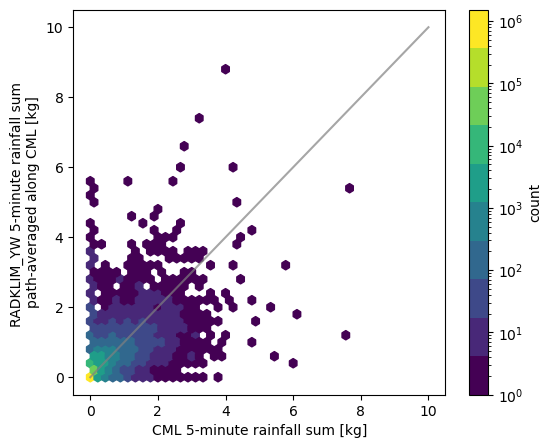

In [24]:
rainsum_5min = ds_cmls.sel(channel_id="channel_1").R.resample(time="5min").sum() / 60

fig, ax = plt.subplots(figsize=(6, 5))
hx = ax.hexbin(
    rainsum_5min.values.T.flatten(),
    path_ref.rainfall_amount.values.flatten(),
    mincnt=1,
    bins="log",
    gridsize=45,
    extent=(0, 10, 0, 10),
    cmap=plt.get_cmap('viridis', 10),
)
ax.plot([0, 10], [0, 10], color='gray', alpha=0.7)
ax.set_xlabel('CML 5-minute rainfall sum [kg]');
ax.set_ylabel('RADKLIM_YW 5-minute rainfall sum \npath-averaged along CML [kg]');
cbar = fig.colorbar(hx)
cbar.set_label('count')

Calculate several performance metrics. `rainfall_threshold_wet` defines the threshold below which a timestep is considered as dry.


In [25]:
metrics = pycml.validation.stats.calc_rain_error_performance_metrics(
    rainsum_5min.values.T.flatten(),
    path_ref.rainfall_amount.values.flatten(),
    rainfall_threshold_wet=0.1)

[print(f'{metric}={value}') for metric, value in zip(metrics._fields, metrics)];

pearson_correlation=0.6834089746878393
coefficient_of_variation=8.645900769042425
root_mean_square_error=0.06931807001601878
mean_absolute_error=0.011792944233870705
R_sum_reference=12630.475911611955
R_sum_predicted=24069.548867923764
R_mean_reference=0.007973820535578095
R_mean_predicted=0.015195489416887425
false_wet_rate=0.02548175019913133
missed_wet_rate=0.1582229750538959
false_wet_precipitation_rate=0.23285533921513088
missed_wet_precipitation_rate=0.25616575706855554
rainfall_threshold_wet=0.1
N_all_pairs=1584000
N_nan_pairs=7
N_nan_reference_only=0
N_nan_predicted_only=7


# Create rainfall fields via IDW interpolation 

First, we combine all CMLs into one `xarray.Dataset` because this is the way our interpolator function requires its input. In addtion,  resampling to the desired temporal aggregation is also much faster when done for one large `Dataset` instead of iterating over the `Dataset`s of the individual CMLs to do the resampling.

We resample the CML rain rate data from 1 minute resolution with raw time stamps (which are, in our case, not located at the full minutes) to 1-hour averages from which we want to interpolat the maps.

In [26]:
cmls_R_1h = ds_cmls.R.resample(time='1h', label='right').mean().to_dataset()
cmls_R_1h

<xarray.Dataset>
Dimensions:           (cml_id: 500, channel_id: 2, time: 264)
Coordinates:
  * cml_id            (cml_id) <U3 '0' '1' '2' '3' ... '496' '497' '498' '499'
    length            (cml_id) float64 6.179 5.673 7.52 ... 8.472 14.57 4.994
    site_a_latitude   (cml_id) float64 58.26 58.09 58.19 ... 57.51 57.77 57.07
    site_a_longitude  (cml_id) float64 1.388 1.637 1.359 ... 2.022 1.471 2.09
    site_b_latitude   (cml_id) float64 58.25 58.13 58.21 ... 57.47 57.83 57.07
    site_b_longitude  (cml_id) float64 1.304 1.59 1.461 ... 2.118 1.298 2.023
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 2.491e+10 ... 2.598e+10
    polarization      (cml_id, channel_id) object 'V' 'V' 'H' ... 'V' 'V' 'V'
  * time              (time) datetime64[ns] 2018-05-10T01:00:00 ... 2018-05-21
Data variables:
    R                 (cml_id, channel_id, time) float64 0.0 0.0 0.0 ... 0.0 0.0

Add coordinates of center location of CMLs

In [27]:
cmls_R_1h['lat_center'] = (cmls_R_1h.site_a_latitude + cmls_R_1h.site_b_latitude)/2
cmls_R_1h['lon_center'] = (cmls_R_1h.site_a_longitude + cmls_R_1h.site_b_longitude)/2

Set up the IDW interpolator

In [28]:
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15, 
    p=2, 
    exclude_nan=True, 
    max_distance=0.3,
)

Next, we interpolate and plot a rainfall map of the rainfall sum over the full period of our dataset.

Note that we leave out CMLs with a `wet_fraction` > 0.3 because, as we have analyzed above, these contain a lot of erratic fluctuations. Also note that this is a primitive way of filtering out CMLs with erratic fluctuations. There are better ones, but we want to use something very simple here. If you want you can experiment here with different thresholds and investigate the effect on the resulting rainfall map.

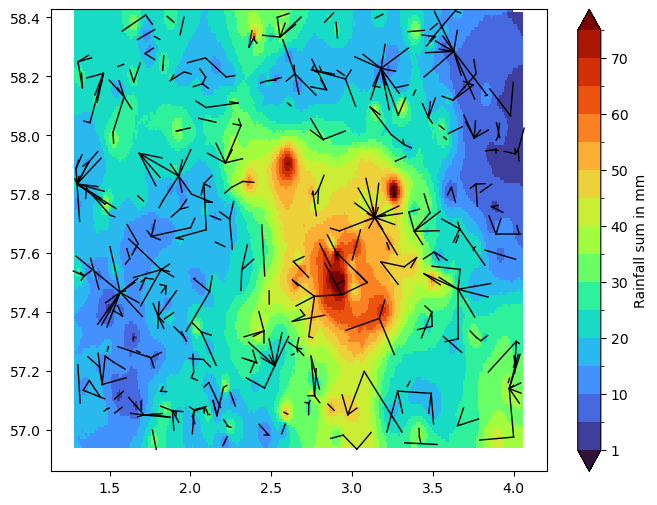

In [29]:
def plot_cml_lines(ds_cmls, ax):
    ax.plot(
        [ds_cmls.site_a_longitude, ds_cmls.site_b_longitude],
        [ds_cmls.site_a_latitude, ds_cmls.site_b_latitude],
        'k',
        linewidth=1,
    )

R_grid = idw_interpolator(
    x=cmls_R_1h.lon_center, 
    y=cmls_R_1h.lat_center, 
    z=cmls_R_1h.R.isel(channel_id=1).sum(dim='time').where(ds_cmls.wet_fraction < 0.3), 
    resolution=0.01,
)

bounds = np.arange(0, 80, 5.0)
bounds[0] = 1
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

fig, ax = plt.subplots(figsize=(8, 6))
pc = plt.pcolormesh(
    idw_interpolator.xgrid, 
    idw_interpolator.ygrid, 
    R_grid, 
    shading='nearest', 
    cmap='turbo',
    norm=norm,
)
plot_cml_lines(cmls_R_1h, ax=ax)
fig.colorbar(pc, label='Rainfall sum in mm');

Plot 1-hour rainfall maps for a selected period. 

Note that this period was selected manually here and is selected based on the index-offset `i + 88`.

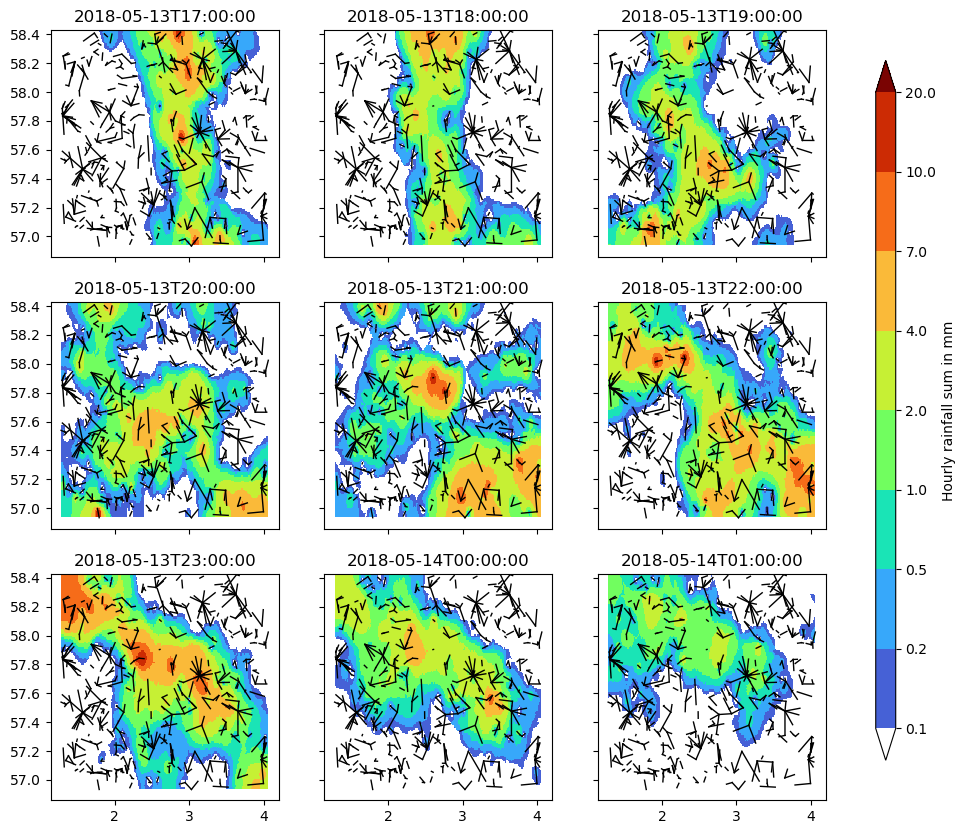

In [30]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20] 
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
cmap = plt.get_cmap('turbo').copy()
cmap.set_under('w')

for i, axi in enumerate(ax.flat):
    R_grid = idw_interpolator(
        x=cmls_R_1h.lon_center, 
        y=cmls_R_1h.lat_center, 
        z=cmls_R_1h.R.isel(channel_id=1).isel(time=i + 88).where(ds_cmls.wet_fraction < 0.3), 
        resolution=0.01,
    )
    pc = axi.pcolormesh(
        idw_interpolator.xgrid, 
        idw_interpolator.ygrid, 
        R_grid, 
        shading='nearest', 
        cmap=cmap,
        norm=norm,
    )
    axi.set_title(str(cmls_R_1h.time.values[i + 88])[:19])
    
    plot_cml_lines(cmls_R_1h, ax=axi)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(pc, cax=cbar_ax, label='Hourly rainfall sum in mm', );